In [50]:
#%%
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from scipy.optimize import minimize
from datetime import datetime
from pricing_model import EuropeanOptions


class ModelCalibrator:
    """Class for calibrating option pricing model parameters
    using market data for a specific ticker"""

    def __init__(self, ticker):
        """
        Initialize the calibrator with a specific ticker

        Args:
            ticker (str): Stock symbol (e.g., 'AAPL', 'GOOGL')
        """
        self.ticker = ticker
        self.stock_data = None
        self.option_chain = None
        self.spot_price = None
        self.risk_free_rate = None
        self.dividend_yield = None
        self.historical_volatility = None
        self.expiry_dates = None

    def fetch_market_data(self, period="1y"):
        """
        Fetch market data for the specified ticker

        Args:
            period (str): Period for historical data (e.g., '1y', '6mo')
        """
        stock = yf.Ticker(self.ticker)
        self.stock_data = stock.history(period=period)

        self.spot_price = self.stock_data["Close"].iloc[-1]

        log_returns = np.log(self.stock_data["Close"] / self.stock_data["Close"].shift(1))
        self.historical_volatility = log_returns.std() * np.sqrt(252)  # Annualization

        self.dividend_yield = stock.info.get("dividendYield", 0.0)

        self.risk_free_rate = 0.03

        self.option_chain = stock.option_chain
        self.expiry_dates = stock.options

        print(f"Data retrieved for {self.ticker}")
        print(f"Spot price: {self.spot_price:.2f}")
        print(f"Historical volatility: {self.historical_volatility:.2%}")
        print(f"Dividend yield: {self.dividend_yield:.2%}")
        print(f"Risk-free rate: {self.risk_free_rate:.2%}")
        print(f"Available expiry dates: {self.expiry_dates}")

    def get_option_data(self, expiry_date):
        """
        Get option data for a specific expiry date

        Args:
            expiry_date (str): Expiry date in 'YYYY-MM-DD' format

        Returns:
            tuple: (calls_df, puts_df) DataFrames for calls and puts
        """
        if self.option_chain is None:
            raise ValueError(
                "Option data not available. Run fetch_market_data() first."
            )

        try:
            options = self.option_chain(expiry_date)
            return options.calls, options.puts
        except Exception as e:
            print(f"No options available for date {expiry_date}: {e}")
            return None, None

    def calculate_time_to_maturity(self, expiry_date):
        """
        Calculate time to maturity in years

        Args:
            expiry_date (str): Expiry date in 'YYYY-MM-DD' format

        Returns:
            float: Time to maturity in years
        """
        expiry = datetime.strptime(expiry_date, "%Y-%m-%d")
        today = datetime.now()
        days = (expiry - today).days
        return max(days, 1) / 365.0  # Normalize by 365 days

    def calibrate_implied_volatility(self, expiry_date, option_type="call"):
        """
        Calibrate implied volatility for different strikes

        Args:
            expiry_date (str): Expiry date in 'YYYY-MM-DD' format
            option_type (str): Option type ('call' or 'put')

        Returns:
            tuple: (strikes, implied_vols) Strike prices and implied volatilities
        """
        calls, puts = self.get_option_data(expiry_date)

        if option_type == "call":
            options_df = calls
        else:
            options_df = puts

        if options_df is None:
            return None, None

        options_df = options_df[options_df["volume"] > 10]

        maturity = self.calculate_time_to_maturity(expiry_date)

        model = EuropeanOptions(
            S0=self.spot_price,
            strike_price=100,  # Will be updated
            maturity=maturity,
            sigma=self.historical_volatility,
            mu=np.mean(np.log(self.stock_data["Close"] / self.stock_data["Close"].shift(1))) * 252,  # Annualized drift
            r=self.risk_free_rate,
            dividend=self.dividend_yield,
        )

        strikes = []
        implied_vols = []

        for _, row in options_df.iterrows():
            strike = row["strike"]
            market_price = row["lastPrice"]

            # Calculate implied volatility
            iv = model.implied_volatility(strike, market_price, option_type)

            if not np.isnan(iv) and 0.01 < iv < 2.0:  # Filter outliers
                strikes.append(strike)
                implied_vols.append(iv)

        return np.array(strikes), np.array(implied_vols)

    def plot_volatility_smile(self, expiry_date, option_type="call"):
        """
        Plot volatility smile for a given expiry date

        Args:
            expiry_date (str): Expiry date in 'YYYY-MM-DD' format
            option_type (str): Option type ('call' or 'put')
        """
        strikes, implied_vols = self.calibrate_implied_volatility(expiry_date, option_type)

        if strikes is None or len(strikes) == 0:
            print("Not enough data to plot volatility smile")
            return

        # Calculate moneyness (K/S)
        moneyness = strikes / self.spot_price

        plt.figure(figsize=(12, 6))
        plt.scatter(moneyness, implied_vols * 100, marker="o")
        plt.plot(moneyness, implied_vols * 100, "r--")

        plt.axvline(x=1, color="gray", linestyle="--")
        plt.xlabel("Moneyness (K/S)")
        plt.ylabel("Implied Volatility (%)")
        plt.title(f"Volatility Smile for {self.ticker} - {expiry_date} ({option_type})")
        plt.grid(True)
        plt.savefig(f"smile_volatility_{self.ticker}_{expiry_date}_{option_type}.png")

    def calibrate_model(self, expiry_date, option_type="call"):
        """
        Calibrate model parameters to match market prices

        Args:
            expiry_date (str): Expiry date in 'YYYY-MM-DD' format
            option_type (str): Option type ('call' or 'put')

        Returns:
            dict: Calibrated parameters
        """
        calls, puts = self.get_option_data(expiry_date)

        if option_type == "call":
            options_df = calls
        else:
            options_df = puts

        if options_df is None or len(options_df) < 5:
            print("Not enough data to calibrate the model")
            return None

        options_df = options_df[options_df["volume"] > 10]

        maturity = self.calculate_time_to_maturity(expiry_date)

        def objective_function(params):
            sigma = params[0]

            model = EuropeanOptions(
                S0=self.spot_price,
                strike_price=100,
                maturity=maturity,
                sigma=sigma,
                r=self.risk_free_rate,
                dividend=self.dividend_yield,
            )

            total_error = 0
            for _, row in options_df.iterrows():
                strike = row["strike"]
                market_price = row["lastPrice"]

                model.K = strike

                if option_type == "call":
                    model_price = model.price_call()
                else:
                    model_price = model.price_put()

                # Squared error
                error = (model_price - market_price) ** 2
                total_error += error

            return total_error

        initial_params = [self.historical_volatility]
        bounds = [(0.01, 2.0)]  # Constraints on volatility

        result = minimize(objective_function, initial_params, bounds=bounds, method="L-BFGS-B")

        if result.success:
            calibrated_sigma = result.x[0]

            calibrated_params = {
                "S0": self.spot_price,
                "sigma": calibrated_sigma,
                "r": self.risk_free_rate,
                "q": self.dividend_yield,
                "T": maturity,
            }

            print(f"Successful calibration for {self.ticker} - {expiry_date}")
            print(f"Calibrated volatility: {calibrated_sigma:.2%}")
            print(f"Historical volatility: {self.historical_volatility:.2%}")

            return calibrated_params
        else:
            print("Calibration failed")
            return None


In [52]:
ticker= "AAPL"
calib = ModelCalibrator(ticker)

In [66]:
calib.fetch_market_data()

Data retrieved for AAPL
Spot price: 195.27
Historical volatility: 32.87%
Dividend yield: 53.00%
Risk-free rate: 3.00%
Available expiry dates: ('2025-05-30', '2025-06-06', '2025-06-13', '2025-06-20', '2025-06-27', '2025-07-18', '2025-08-15', '2025-09-19', '2025-10-17', '2025-11-21', '2025-12-19', '2026-01-16', '2026-03-20', '2026-06-18', '2026-09-18', '2026-12-18', '2027-01-15', '2027-06-17', '2027-12-17')


In [56]:
calls, puts = calib.get_option_data("2025-06-06")

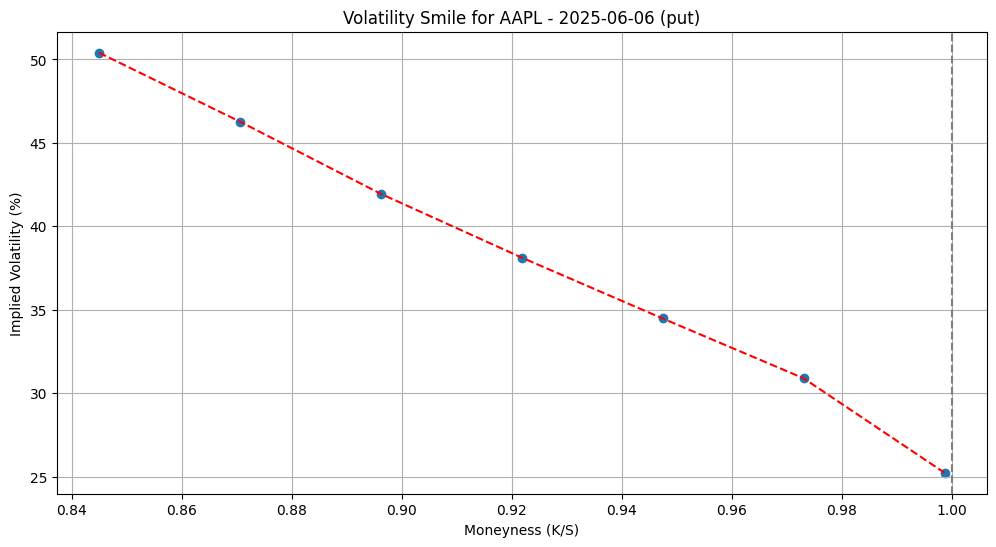

In [65]:
calib.plot_volatility_smile("2025-06-06", "put")